## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from imblearn.over_sampling import RandomOverSampler



In [2]:
# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Text Preprocessing, Tokenization, and Sequence Padding

### Text Pre Processing Pipeline



The `preprocess_text` function performs the following steps to clean the input text:

- Converts all characters to **lowercase**
- Removes **URLs**, **mentions (@username)**, and **hashtags (#hashtag)**
- Strips out **punctuation** and **numbers**
- Removes **stopwords** (common words like "the", "is", "and")
- Applies **lemmatization** to reduce words to their base form (e.g., "running" → "run")

These preprocessing steps help reduce noise and standardize the text, making it more suitable for training an RNN model.


In [3]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    processed_text = ' '.join(tokens)
    return processed_text

### Load the dataset

In [4]:
# Example: Load a CSV file with columns "text" and "label"
df = pd.read_csv("Hotel_Reviews.csv")
df.head()


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


### Clean the text
Apply the cleaning on each row and store it in a clean_text column

In [5]:
df['cleaned_text'] = df['Review'].apply(preprocess_text)
df

,Review,Rating,cleaned_text
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best kept secret rd time staying charm star ca...
20487,great location price view hotel great quick pl...,4,great location price view hotel great quick pl...
20488,"ok just looks nice modern outside, desk staff ...",2,ok look nice modern outside desk staff nt part...
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruined vacation hotel opened sept ...


### Data Visualisation

In [6]:
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

#### Label Distribution

We check the distribution of sentiment labels in the dataset using `value_counts()`:


In [7]:
label_counts = df['Rating'].value_counts()
print(label_counts)

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64


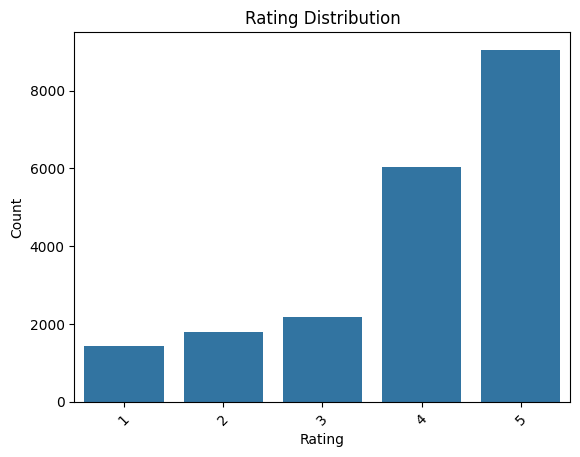

In [8]:
# Label Distribution
sns.countplot(x='Rating', data=df)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Check your DataFrame columns
print(df.columns)

# Use actual column names from the output above
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['Review'])  # use actual column name
y = df['Rating']                         # use actual column name

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

balanced_df = pd.DataFrame(X_resampled.toarray(), columns=vectorizer.get_feature_names_out())
balanced_df['Rating'] = y_resampled.values

print("Original class distribution:")
print(df['Rating'].value_counts())

print("\nBalanced class distribution:")
print(balanced_df['Rating'].value_counts())

Index(['Review', 'Rating', 'cleaned_text'], dtype='object')
Original class distribution:
Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64

Balanced class distribution:
Rating
4    9054
2    9054
3    9054
5    9054
1    9054
Name: count, dtype: int64


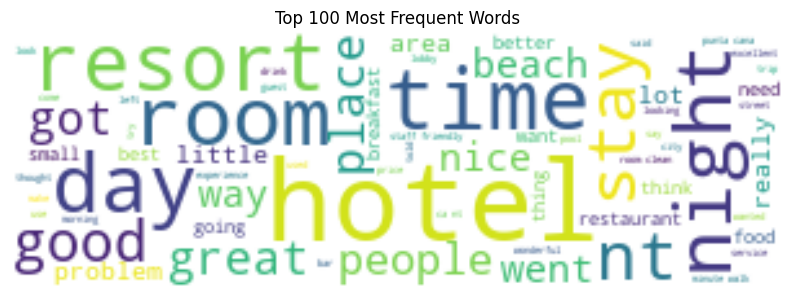

In [11]:
# --- Visualization: Word Cloud (Top 100 Words)
all_words = ''.join(df['cleaned_text'])

# Generate WordCloud with only top 100 words
wordcloud = WordCloud(
  width=300,
  height=100,
  background_color='white',
  max_words=100 # Limit to top 100 words

).generate(all_words)
# Plot settings
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

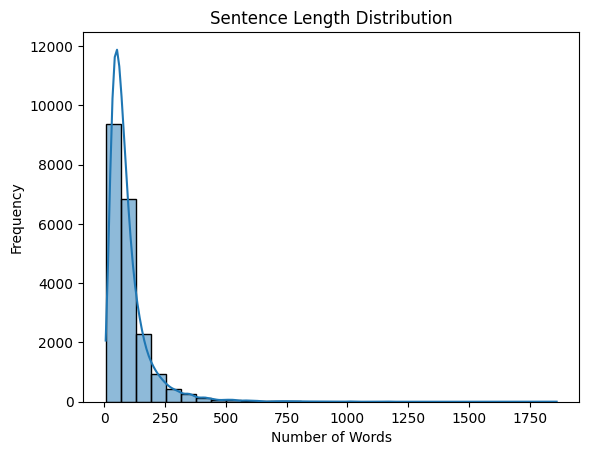

In [12]:
df['text_length'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


The histogram shows the distribution of sentence lengths (in number of words) across the dataset.

- Most sentences contain **between 5 and 15 words**, with a peak around **10 words**.
- There are fewer very short or very long sentences.
- This distribution helps in choosing an appropriate **sequence length** for padding when preparing input for the RNN.

Based on this, we can set a maximum sequence length that captures most sentences without excessive padding or truncation.


### Splitting Data

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [14]:
X = df['cleaned_text']
y = df['Rating']  # expected values: 'yes', 'no', 'neutral'

# Split: 70% train, 15% validation, 15% test (stratified)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y 
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 14804
Validation size: 2613
Test size: 3074


### Train, Validation, and Test Split

The dataset is split into three parts using stratified sampling to maintain the label distribution across all sets:

- **Training set (70%)**: Used to train the model  
- **Validation set (15%)**: Used to tune model parameters and prevent overfitting  
- **Test set (15%)**: Used for final evaluation on unseen data

### Tokenization and Padding

In [15]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Only fit on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)  # Tokenize validation set
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine max_len using 95th percentile from training data
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

# Pad sequences to max_len
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')  # Pad validation set
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


- A `Tokenizer` is initialized to keep the top 10,000 most frequent words. An out-of-vocabulary (OOV) token (`<OOV>`) is used for unseen words.
- The tokenizer is **fitted only on the training data** to avoid data leakage.
- Text data is converted into sequences of integers (each word → index).

To ensure uniform input length for the RNN:
- We calculate the **95th percentile** of sequence lengths in the training set.
- All sequences are **padded or truncated** to this `max_len` using **post-padding** and **post-truncating**.

This preserves most sentence lengths while avoiding excessive padding.


#### Label Encoding and One-Hot Conversion

In [16]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)  # Fit only on training labels

# Transform validation and test labels
y_val_enc = label_encoder.transform(y_val) 
y_test_enc = label_encoder.transform(y_test) 

# Convert to one-hot for categorical_crossentropy
y_train_cat = to_categorical(y_train_enc, num_classes=5)
y_val_cat = to_categorical(y_val_enc, num_classes=5)  # Encode validation labels
y_test_cat = to_categorical(y_test_enc, num_classes=5)

- Labels are first encoded using `LabelEncoder`, which converts categorical labels (`neutral`, `positive`, `negative`) into integer values (e.g., 0, 1, 2).
- The encoder is **fitted only on the training labels** to avoid data leakage.
- The same encoder is then used to transform the validation and test labels.

Since we are using `categorical_crossentropy` as the loss function, we convert the encoded labels into **one-hot vectors** using `to_categorical()`.

This format is required for multi-class classification with neural networks.


#### Visualize Sequence Length Distribution

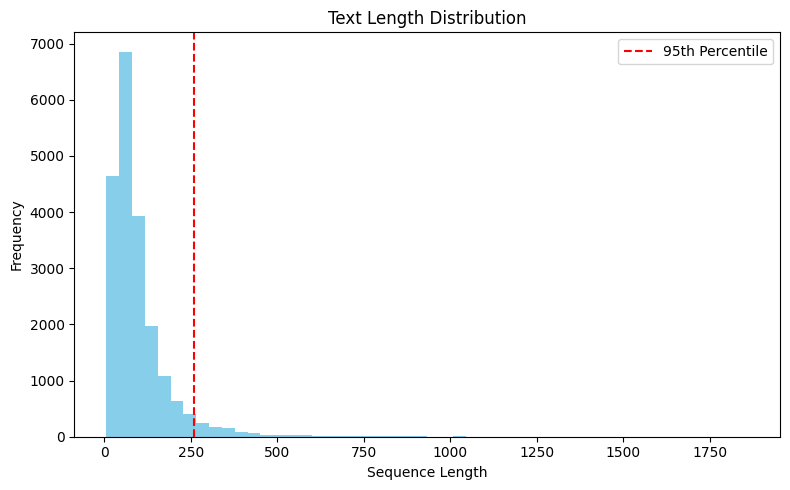

In [17]:
X_seq = tokenizer.texts_to_sequences(df['cleaned_text'])
all_seq_lengths = [len(seq) for seq in X_seq]

plt.figure(figsize=(8, 5))
plt.hist(all_seq_lengths, bins=50, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(np.percentile(all_seq_lengths, 95), color='red', linestyle='dashed', label='95th Percentile')
plt.legend()
plt.tight_layout()
plt.show()

 - The 95th percentile indicates the value below which 95% of the sequence lengths fall. In this case, about 95% of the sequences are 22 tokens or fewer in length.
- This suggests that most of the text sequences in the dataset are relatively short, with only a small proportion of sequences exceeding 22 tokens.


## Model Building and Training

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
import gensim
import numpy
import scipy

print("Gensim version:", gensim.__version__)
print("Numpy version:", numpy.__version__)
print("Scipy version:", scipy.__version__)


Gensim version: 4.3.2
Numpy version: 1.24.4
Scipy version: 1.10.1


### Simple RNN

#### Simple RNN Model for Text Classification

1. **Text Preprocessing**:
    - The input text is first tokenized and converted into sequences of integers using a tokenizer. This allows the model to work with numerical data, which is essential for training neural networks.
    - The sequences are then padded to ensure that all inputs have the same length, which is required for batch processing.

2. **Embedding Layer**:
    - The **Embedding layer** transforms the integer-encoded words into dense vectors of fixed size (`embedding_dim = 128`). These vectors capture the semantic meaning of words based on their context and relationships in the training data.

3. **SimpleRNN Layer**:
    - The **SimpleRNN layer** is the core of the model, processing the sequential data and capturing temporal dependencies. This allows the model to understand the context of words based on the words that preceded them. We use 64 RNN units to control the model’s capacity to remember sequence information.

4. **Output Layer**:
    - The **Dense layer** with 3 units and a **softmax activation** is used for multi-class classification. It outputs probabilities for each of the three classes, allowing the model to predict the most likely class for each input text.

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Input
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Parameters (match with preprocessing step)
vocab_size = min(len(tokenizer.word_index) + 1, 10000)  # tokenizer limit or actual vocab
embedding_dim = 128
rnn_units = 64
max_length = X_train_pad.shape[1]  # use the actual padded length from earlier

# Build the Simple RNN model
model_rnn = Sequential([
    Input(shape=(max_length,)),  # Still define input shape here
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(units=rnn_units),
    Dense(5, activation='softmax')
])

In [21]:
# Compile the model
model_rnn.compile(
    loss='categorical_crossentropy',  # required for multi-class
    optimizer='adam',
    metrics=['accuracy']
)

In [22]:
# Model summary
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 259, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,292,677 (4.93 MB)

 Trainable params: 1,292,677 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

Model Summary

The model consists of three layers:

1. **Embedding Layer** (530,816 parameters):
    - Transforms input sequences into dense 128-dimensional vectors. This helps the model understand semantic relationships between words.

2. **SimpleRNN Layer** (12,352 parameters):
    - Processes the sequences with 64 units, capturing the temporal dependencies in the text data.

3. **Dense Layer** (195 parameters):
    - The output layer with 3 units, corresponding to the number of classes, uses a softmax activation to predict probabilities for each class.

Total Parameters:
- **Trainable Parameters**: 543,363 (approximately 2.07 MB)
- This model has a manageable number of parameters, making it suitable for moderate-sized datasets and typical text classification tasks.


### LSTM with a Trainable Embedding layer

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


We now try to improve the accuracy by building a **Long Short-Term Memory (LSTM)** network, an advanced form of RNN, to classify text data.

1. **Embedding Layer**:
    - The **Embedding layer** transforms input word sequences into dense vectors of size 128, allowing the model to capture semantic relationships between words.

2. **LSTM Layer**:
    - The **LSTM layer** with 64 units processes the input sequences and captures long-range dependencies in the text. The `dropout=0.2` and `recurrent_dropout=0.2` parameters help prevent overfitting by randomly setting a fraction of inputs and recurrent states to zero during training.

3. **Fully Connected Layers**:
    - Two **Dense layers** (with 128 and 256 units, respectively) use **ReLU activation** to introduce non-linearity, helping the model learn complex patterns. These layers act as classifiers that refine the model's understanding of the data.

4. **Output Layer**:
    - The final **Dense layer** with 3 units and a **softmax activation** outputs the probabilities of each class, making the model suitable for multi-class classification.


In [24]:
# Parameters
vocab_size = min(len(tokenizer.word_index) + 1, 10000)
embedding_dim = 128
lstm_units = 64
max_length = X_train_pad.shape[1]

model_lstm = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])


In [25]:
# Compile the model
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [26]:
# Summary
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 259, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,372,037 (5.23 MB)

 Trainable params: 1,372,037 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

Model Summary

The model consists of the following layers:

1. **Embedding Layer** (530,816 parameters):
    - Converts input sequences of words into dense 128-dimensional vectors.

2. **LSTM Layer** (49,408 parameters):
    - The LSTM layer processes the sequences, capturing long-term dependencies in the text with 64 units. The LSTM helps the model understand context across words in the sequence.

3. **Dense Layer** (8,320 parameters):
    - This layer has 128 units and uses ReLU activation, helping the model learn more complex patterns.

4. **Dense Layer** (33,024 parameters):
    - Another fully connected layer with 256 units, also using ReLU activation for further non-linear transformations.

5. **Output Layer** (771 parameters):
    - A dense layer with 3 units and softmax activation to output probabilities for the 3 classes, making the model suitable for multi-class classification.

Total Parameters:
- **Trainable Parameters**: 622,339 (approximately 2.37 MB)


###  LSTM with Pretrained Word2Vec Embeddings

### Loading Pre-trained GloVe Embeddings

In this snippet, we are loading a pre-trained **GloVe** embedding model using **gensim**'s API:

 **GloVe (Global Vectors for Word Representation)**:
    - GloVe is an unsupervised learning algorithm for obtaining word representations by leveraging word co-occurrence statistics from a corpus. Pre-trained GloVe vectors, such as those trained on Wikipedia and Gigaword data, are widely used for natural language processing tasks.

By using pre-trained embeddings, we avoid the need to train the embedding layer from scratch and benefit from the semantic relationships captured by the GloVe model during training.


In [27]:
import gensim.downloader as api

# Load the smallest GloVe embedding (50 dimensions)
embedding_model = api.load('glove-wiki-gigaword-50')


#### Embedding Matrix Creation

This code creates an embedding matrix where each word in the tokenizer’s vocabulary is mapped to its corresponding pre-trained GloVe word vector. If a word is found in the GloVe model, its vector is assigned to the matrix. This matrix is then used to initialize the Embedding layer in the model.


In [28]:
import numpy as np

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 50  # Because you're using 50-dimensional GloVe

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in tokenizer.word_index.items():
    if word in embedding_model:
        embedding_matrix[index] = embedding_model[word]


#### Using Pre-trained GloVe Embeddings

We initialize an embedding layer using pre-trained GloVe word vectors. The word vectors are loaded into the embedding layer, which will be used to convert words into dense vectors during model training. By setting the embeddings as non-trainable, the model will use these static pre-trained vectors as features without modifying them during training, ensuring the model benefits from the semantic relationships learned in the GloVe corpus.


In [29]:
from tensorflow.keras.layers import Embedding

max_sequence_length = 100  # Adjust as needed

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_sequence_length,  # Use max_sequence_length here
    trainable=False  # Keep it False to use static GloVe embeddings
)


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### Building the LSTM Model

A Sequential model is built with the following layers:

1. The pre-trained **Embedding layer** is added to handle the input sequences.
2. An **LSTM layer** is included to process the sequences, capturing long-term dependencies in the data.
3. The final **Dense layer** with 3 units and a softmax activation function is used for multi-class classification, outputting the probabilities for each class.

This architecture is designed to classify sequences of text based on the learned patterns from the LSTM layer.


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
# Define the model
model = Sequential()

# Add the embedding layer
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix],  # Pre-trained embedding matrix
                    input_length=max_sequence_length, 
                    trainable=False))  # Set to False to keep GloVe embeddings fixed

# Add an LSTM layer
model.add(LSTM(128, return_sequences=False))
model.build(input_shape=(None, max_sequence_length))
# Add a Dense output layer (5 classes as example)
model.add(Dense(5, activation='softmax'))  # Softmax for multi-class classification

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [32]:
# Summary of the model
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 100, 50)             │       2,879,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │          91,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,971,993 (11.34 MB)

 Trainable params: 92,293 (360.52 KB)

 Non-trainable params: 2,879,700 (10.99 MB)

## Model Training and Evaluation

### Simple RNN

In [33]:
# Set up callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_rnn_model.h5', monitor='val_accuracy', save_best_only=True)


In [34]:
history_rnn = model_rnn.fit(
    X_train_pad, y_train_cat, 
    validation_data=(X_val_pad, y_val_cat),
    epochs=20, 
    batch_size=32, 
    
)

Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.4376 - loss: 1.3803 - val_accuracy: 0.4386 - val_loss: 1.3610
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.4644 - loss: 1.3427 - val_accuracy: 0.4359 - val_loss: 1.3713
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.4787 - loss: 1.2893 - val_accuracy: 0.4328 - val_loss: 1.3859
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - accuracy: 0.4776 - loss: 1.2920 - val_accuracy: 0.4359 - val_loss: 1.3877
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - accuracy: 0.4826 - loss: 1.2793 - val_accuracy: 0.4328 - val_loss: 1.4030
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.4885 - loss: 1.2675 - val_accuracy: 0.4374 - val_loss: 1.3962
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 28s 60ms/step - accuracy: 0.4826 - loss: 1.2769 - val_accuracy: 0.3957 - val_loss: 1.4061
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - accuracy: 0.4335 - loss: 1.3749 - 

In [35]:
# Evaluate test accuracy
loss, accuracy = model_rnn.evaluate(X_test_pad, y_test_cat, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4341 - loss: 1.3760
Test Loss: 1.3566
Test Accuracy: 0.4463


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [37]:
# Predict class probabilities
y_pred_rnn = model_rnn.predict(X_test_pad)
# Convert to predicted class labels (index of max prob)
y_pred = np.argmax(y_pred_rnn, axis=1)
# Convert one-hot test labels back to class indices
y_true = np.argmax(y_test_cat, axis=1)

target_names = [str(cls) for cls in label_encoder.classes_]

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.12      0.01      0.02       213
           2       0.05      0.00      0.01       269
           3       0.08      0.00      0.01       328
           4       0.41      0.13      0.20       906
           5       0.46      0.92      0.61      1358

    accuracy                           0.45      3074
   macro avg       0.22      0.21      0.17      3074
weighted avg       0.34      0.45      0.33      3074



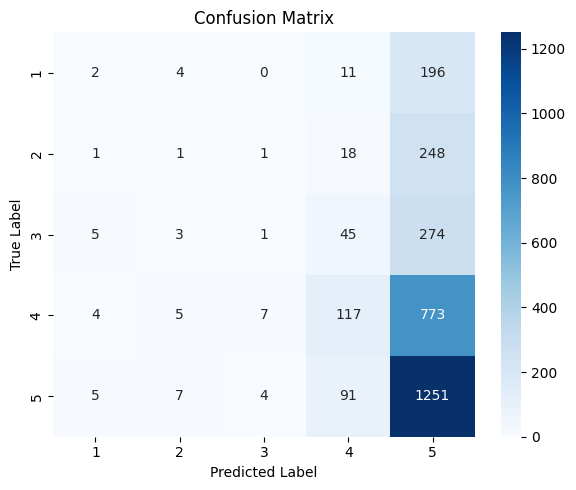

In [38]:

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


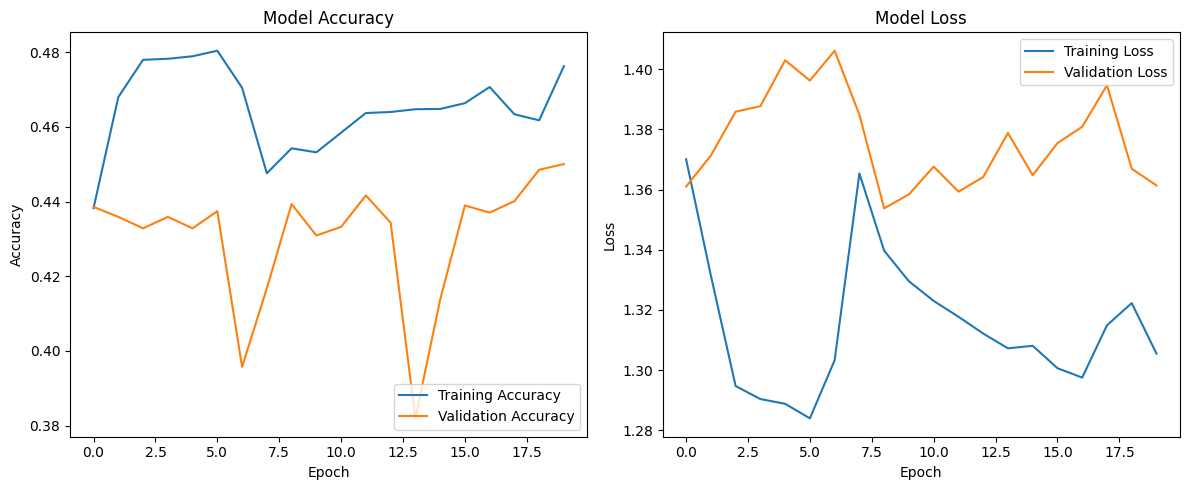

In [39]:
import matplotlib.pyplot as plt

# Get training and validation accuracy and loss
training_accuracy = history_rnn.history['accuracy']
validation_accuracy = history_rnn.history['val_accuracy']
training_loss = history_rnn.history['loss']
validation_loss = history_rnn.history['val_loss']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(training_accuracy, label='Training Accuracy')
ax1.plot(validation_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot loss
ax2.plot(training_loss, label='Training Loss')
ax2.plot(validation_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

### LSTM with a Trainable Embedding layer

In [40]:
# Callbacks
early_stop_lstm = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_lstm = ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy', save_best_only=True)


In [43]:
# Train the model
history_lstm = model_lstm.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop_lstm, checkpoint_lstm],
    
)

Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4401 - loss: 1.3806

463/463 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.4401 - loss: 1.3806 - val_accuracy: 0.4420 - val_loss: 1.3601
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 75s 163ms/step - accuracy: 0.4437 - loss: 1.3644 - val_accuracy: 0.4413 - val_loss: 1.3565
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 78s 168ms/step - accuracy: 0.4405 - loss: 1.3502 - val_accuracy: 0.4397 - val_loss: 1.3617
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 81s 176ms/step - accuracy: 0.4538 - loss: 1.3288 - val_accuracy: 0.4393 - val_loss: 1.3816
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 81s 175ms/step - accuracy: 0.4696 - loss: 1.3155 - val_accuracy: 0.4409 - val_loss: 1.4004
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 86s 185ms/step - accuracy: 0.4736 - loss: 1.3062 - val_accuracy: 0.4401 - val_loss: 1.4168
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 102s 220ms/step - accuracy: 0.4720 - loss: 1.2971 - val_accuracy: 0.4413 - val_loss: 1.4464


In [44]:
# Evaluate test accuracy
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test_cat, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.4269 - loss: 1.3771
Test Loss: 1.3595
Test Accuracy: 0.4405


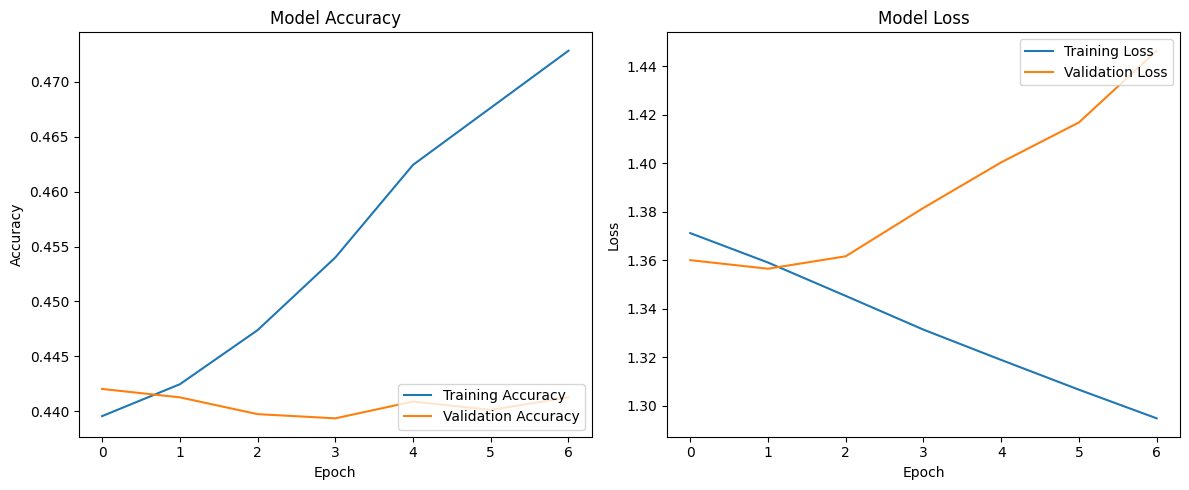

In [45]:
import matplotlib.pyplot as plt

# Get training and validation accuracy and loss
training_accuracy = history_lstm.history['accuracy']
validation_accuracy = history_lstm.history['val_accuracy']
training_loss = history_lstm.history['loss']
validation_loss = history_lstm.history['val_loss']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(training_accuracy, label='Training Accuracy')
ax1.plot(validation_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot loss
ax2.plot(training_loss, label='Training Loss')
ax2.plot(validation_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

In [46]:
# Predict class probabilities using the LSTM model
y_pred_lstm = model_lstm.predict(X_test_pad)

# Convert to predicted class labels (index of max prob)
y_pred = np.argmax(y_pred_lstm, axis=1)

# Convert one-hot test labels back to class indices
y_true = np.argmax(y_test_cat, axis=1)

target_names = [str(c) for c in label_encoder.classes_]

# Classification report with zero_division parameter
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))


97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       213
           2       0.19      0.03      0.05       269
           3       0.00      0.00      0.00       328
           4       0.00      0.00      0.00       906
           5       0.44      0.99      0.61      1358

    accuracy                           0.44      3074
   macro avg       0.13      0.20      0.13      3074
weighted avg       0.21      0.44      0.28      3074



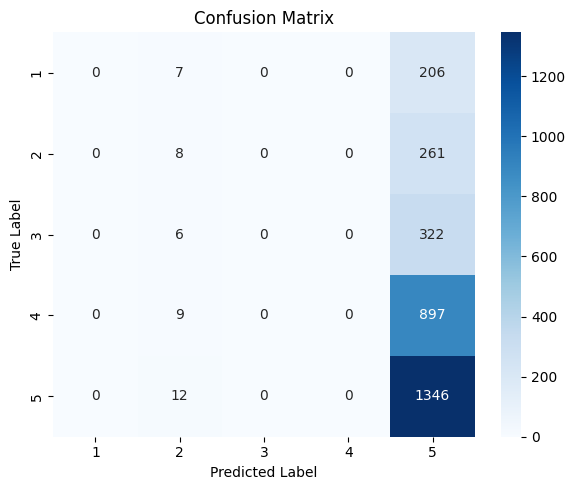

In [47]:

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


###  LSTM with Pretrained Word2Vec Embeddings

In [49]:
# Callbacks
early_stop_w2v = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_w2v = ModelCheckpoint('best_lstm_w2v_Try_model.h5', monitor='val_accuracy', save_best_only=True)

# Train the model
history_w2v_Try = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop_w2v, checkpoint_w2v],
    
)

Epoch 1/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.4357 - loss: 1.3926

463/463 ━━━━━━━━━━━━━━━━━━━━ 116s 223ms/step - accuracy: 0.4357 - loss: 1.3926 - val_accuracy: 0.4416 - val_loss: 1.3585
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 105s 227ms/step - accuracy: 0.4435 - loss: 1.3658 - val_accuracy: 0.4374 - val_loss: 1.3583
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 108s 234ms/step - accuracy: 0.4470 - loss: 1.3549 - val_accuracy: 0.4405 - val_loss: 1.3596
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.4500 - loss: 1.3432

463/463 ━━━━━━━━━━━━━━━━━━━━ 98s 211ms/step - accuracy: 0.4500 - loss: 1.3432 - val_accuracy: 0.4439 - val_loss: 1.3568
Epoch 5/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 102s 221ms/step - accuracy: 0.4442 - loss: 1.3465 - val_accuracy: 0.4413 - val_loss: 1.3568
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 85s 183ms/step - accuracy: 0.4575 - loss: 1.3410 - val_accuracy: 0.4416 - val_loss: 1.3587
Epoch 7/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 61s 133ms/step - accuracy: 0.4485 - loss: 1.3517 - val_accuracy: 0.4409 - val_loss: 1.3578
Epoch 8/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 85s 183ms/step - accuracy: 0.4496 - loss: 1.3504 - val_accuracy: 0.4401 - val_loss: 1.3583
Epoch 9/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 99s 214ms/step - accuracy: 0.4552 - loss: 1.3377 - val_accuracy: 0.4405 - val_loss: 1.3679


In [50]:
# Evaluate test accuracy
loss, accuracy = model.evaluate(X_test_pad, y_test_cat, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.4257 - loss: 1.3764
Test Loss: 1.3599
Test Accuracy: 0.4414


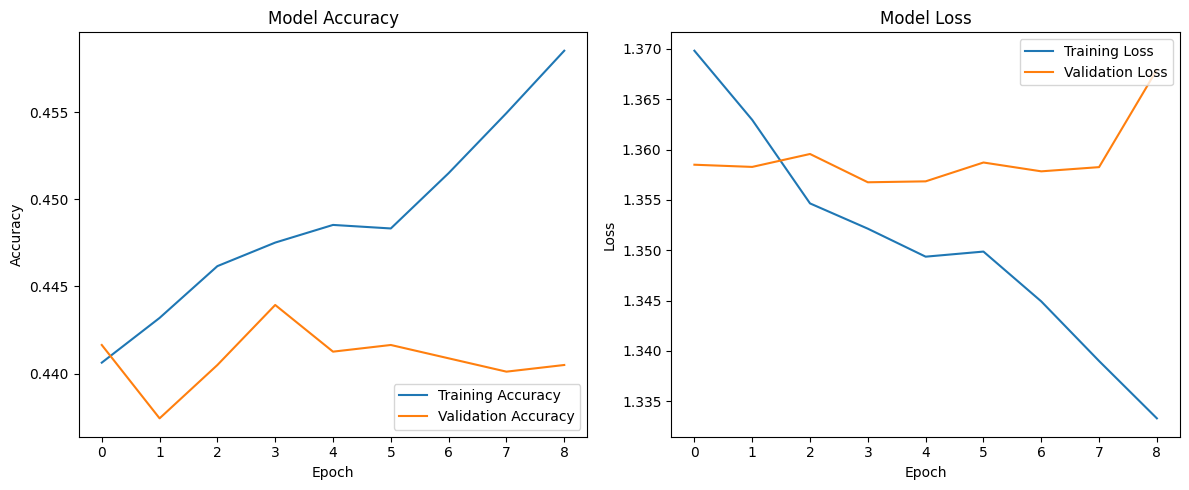

In [51]:
training_accuracy = history_w2v_Try.history['accuracy']
validation_accuracy = history_w2v_Try.history['val_accuracy']
training_loss = history_w2v_Try.history['loss']
validation_loss = history_w2v_Try.history['val_loss']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy
ax1.plot(training_accuracy, label='Training Accuracy')
ax1.plot(validation_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')

# Plot loss
ax2.plot(training_loss, label='Training Loss')
ax2.plot(validation_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()

In [52]:
# Predict class probabilities using the LSTM model
y_pred_probs = model.predict(X_test_pad)

# Convert to predicted class labels (index of max prob)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert one-hot test labels back to class indices
y_true = np.argmax(y_test_cat, axis=1)

target_names = [str(c) for c in label_encoder.classes_]

# Classification report with zero_division parameter
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       213
           2       0.22      0.01      0.01       269
           3       0.00      0.00      0.00       328
           4       0.32      0.02      0.03       906
           5       0.44      0.99      0.61      1358

    accuracy                           0.44      3074
   macro avg       0.20      0.20      0.13      3074
weighted avg       0.31      0.44      0.28      3074



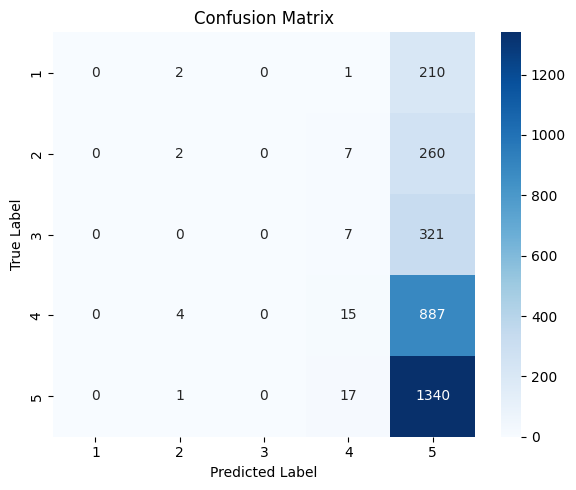

In [53]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


## Comparison of All Models

In [54]:
# Evaluate the models on test data (for example)
rnn_eval = model_rnn.evaluate(X_test_pad, y_test_cat, verbose=0)
lstm_eval = model_lstm.evaluate(X_test_pad, y_test_cat, verbose=0)
word2vec_eval = model.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f"RNN Test Accuracy: {rnn_eval[1]}")
print(f"LSTM Test Accuracy: {lstm_eval[1]}")
print(f"Word2Vec LSTM Test Accuracy: {word2vec_eval[1]}")


RNN Test Accuracy: 0.44632402062416077
LSTM Test Accuracy: 0.440468430519104
Word2Vec LSTM Test Accuracy: 0.44144436717033386


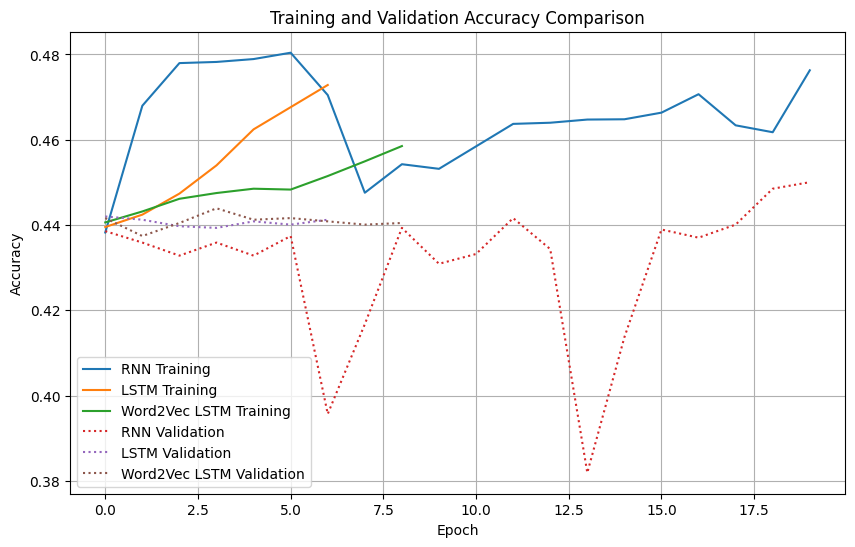

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Training Accuracy (normal lines)
plt.plot(history_rnn.history['accuracy'], label='RNN Training')
plt.plot(history_lstm.history['accuracy'], label='LSTM Training')
plt.plot(history_w2v_Try.history['accuracy'], label='Word2Vec LSTM Training')

# Validation Accuracy (dotted lines)
plt.plot(history_rnn.history['val_accuracy'], label='RNN Validation', linestyle='dotted')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation', linestyle='dotted')
plt.plot(history_w2v_Try.history['val_accuracy'], label='Word2Vec LSTM Validation', linestyle='dotted')

plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

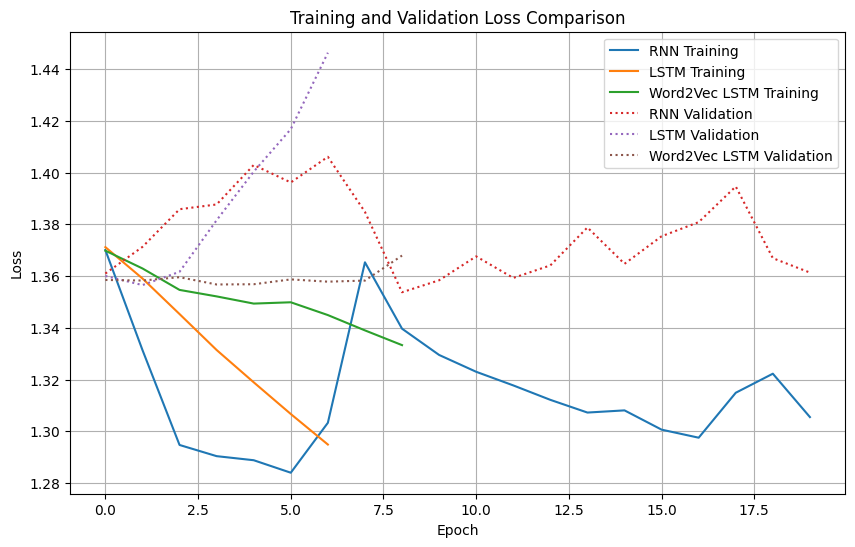

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Training Loss (normal lines)
plt.plot(history_rnn.history['loss'], label='RNN Training')
plt.plot(history_lstm.history['loss'], label='LSTM Training')
plt.plot(history_w2v_Try.history['loss'], label='Word2Vec LSTM Training')

# Validation Loss (dotted lines)
plt.plot(history_rnn.history['val_loss'], label='RNN Validation', linestyle='dotted')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation', linestyle='dotted')
plt.plot(history_w2v_Try.history['val_loss'], label='Word2Vec LSTM Validation', linestyle='dotted')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [57]:
model.save('best_rnn_model.keras')
model.save('best_lstm_model.keras')
model.save('best_lstm_w2v_Try_model.keras')


# GUI

In [66]:
import tkinter as tk
from tkinter import scrolledtext
import threading

# Dummy function to simulate sentiment prediction (replace with your models)
def predict_sentiment(text):
    # This is a placeholder function. Replace it with your actual model inference code.
    # For example, use model.predict(text) or similar methods for your RNN, LSTM, Word2Vec.
    # Returning dummy sentiment predictions for the sake of example.
    return "Positive", "Neutral", "Negative"

def launch_gui():
    root = tk.Tk()
    root.title("Hotel Review Sentiment Analysis")
    root.geometry("600x500")

    # Title
    heading = tk.Label(root, text="Hotel Review Sentiment Analysis", font=("Arial", 16, "bold"))
    heading.pack(pady=10)

    # Input label and text box
    input_label = tk.Label(root, text="Enter your hotel review:")
    input_label.pack()
    input_text = scrolledtext.ScrolledText(root, height=5, width=70)
    input_text.pack(pady=5)

    # Analyse function
    def on_analyse():
        user_input = input_text.get("1.0", tk.END).strip()  # Get the review input
        if user_input:
            # Here you would call the actual sentiment analysis function using your models.
            rnn_result, lstm_result, word2vec_result = predict_sentiment(user_input)
            # Update the results on the GUI
            rnn_output.config(text=f"RNN Sentiment: {rnn_result}")
            lstm_output.config(text=f"LSTM Sentiment: {lstm_result}")
            word2vec_output.config(text=f"Word2Vec Sentiment: {word2vec_result}")

    # Analyse button
    analyse_button = tk.Button(root, text="Analyse", command=on_analyse)
    analyse_button.pack(pady=10)

    # Output labels
    output_label = tk.Label(root, text="Analysis output from models:", font=("Arial", 12, "bold"))
    output_label.pack(pady=10)

    rnn_output = tk.Label(root, text="RNN Sentiment:")
    rnn_output.pack()

    lstm_output = tk.Label(root, text="LSTM Sentiment:")
    lstm_output.pack()

    word2vec_output = tk.Label(root, text="Word2Vec Sentiment:")
    word2vec_output.pack()

    root.mainloop()

# Start GUI in a separate thread (if necessary)
if __name__ == "__main__":
    # Running in a separate thread if necessary (but avoid this in Jupyter Notebook)
    launch_gui()
